In [1]:
import os
import matplotlib.pyplot as plt

if not os.path.exists("lichess_db_puzzle.csv.zst"):
    !wget https://database.lichess.org/lichess_db_puzzle.csv.zst
if not os.path.exists("lichess_db_puzzle.csv"):
    !zstd -d lichess_db_puzzle.csv.zst

In [26]:
import pandas as pd
import chess

# Read CSV and keep only important columns
df = pd.read_csv("lichess_db_puzzle.csv")
df = df[["FEN", "Moves", "Rating", "Themes"]]


In [25]:
def fen_play_first_move_and_force_white(fen, moves):
    board = chess.Board(fen)
    first_move = moves.split()[0]
    # Play the first move of the puzzle, actually setting it up
    board.push_uci(first_move)
    
    # Flip the board if it is black to move
    if board.turn == chess.BLACK:
        board.apply_mirror()
    
    # Return just the FEN of the board
    return board.board_fen()

df["white_to_play_FEN"] = df.apply(lambda r: fen_play_first_move_and_force_white(r["FEN"], r["Moves"]), axis=1)

KeyboardInterrupt: 

In [27]:
# Create one hot encoding of the themes
one_hots = df["Themes"].str.get_dummies(sep=" ")
df = df.join(one_hots)

<Figure size 640x480 with 0 Axes>

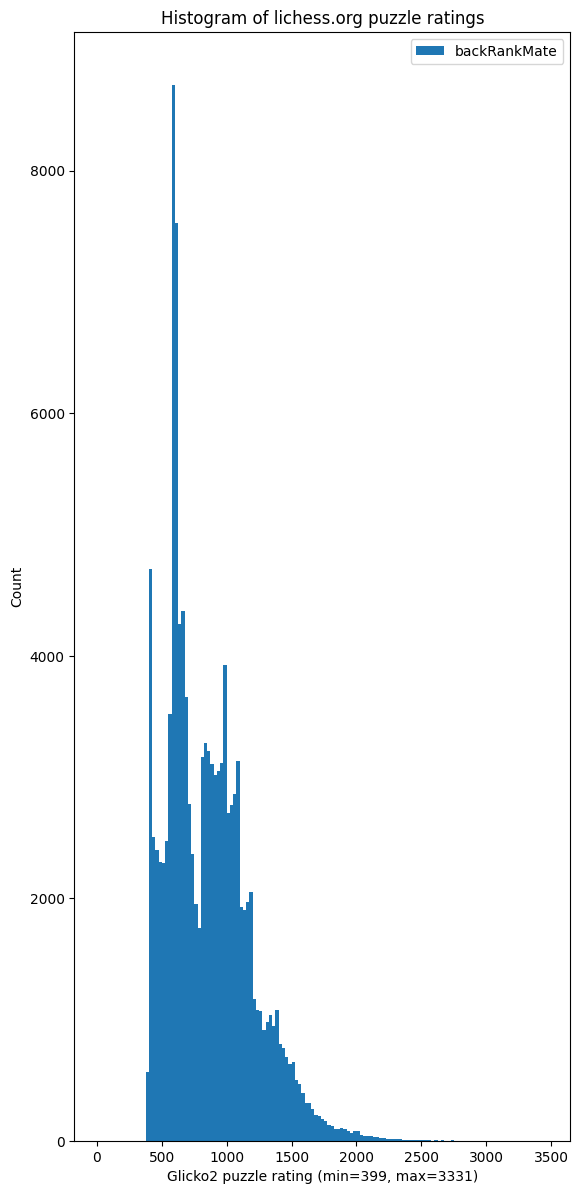

In [65]:
"""
# Histogram of ratings
plt.hist(df["Rating"], bins=[n*25 for n in range(140)])
plt.ylabel("Count")
plt.xlabel(f"Glicko2 puzzle rating (min={df['Rating'].min()}, max={df['Rating'].max()})")
plt.title("Histogram of lichess.org puzzle ratings")
plt.savefig("../report/project/img/puzzle_histogram.png", dpi=250, bbox_inches="tight")
plt.clf()

# Theme counts
all_themes = [(t, df[t].sum()) for t in df.columns 
    if t not in ["FEN", "Moves", "Rating", "Themes", "white_to_play_FEN"]]

all_themes = sorted(all_themes, key=lambda x: x[1])
plt.figure().set_figheight(4.8*3)
plt.barh(*zip(*all_themes))
plt.ylabel(f"Theme (total themes={len(all_themes)})")
plt.xlabel("Count")
plt.title("Counts of all themes in the lichess.org puzzle database")
plt.savefig("../report/project/img/puzzle_theme_counts.png", dpi=250, bbox_inches="tight")
plt.clf()
"""

# Stacked histogram of some themes
for theme in ["backRankMate"]:
    plt.hist(df[df[theme] == 1]["Rating"], bins=[n*25 for n in range(140)], label=theme)

plt.ylabel("Count")
plt.xlabel(f"Glicko2 puzzle rating (min={df['Rating'].min()}, max={df['Rating'].max()})")
plt.title("Histogram of lichess.org puzzle ratings")
plt.legend()

In [14]:
# 80/20 split train/test
train = df.sample(frac=0.8, random_state=1337)
test = df.drop(train.index)

train.to_csv("lichess_db_puzzle_train.csv")
test.to_csv("lichess_db_puzzle_test.csv")